# WestVaco

## Introduction
Westvaco Company is a manufacturer that sells packaging supplies including paper, paperboard, and specialty chemicals. The objective of this case is to automate the truckload assignment process in distribution that was done manually. The truckload assignment is based on the least cost distribution plan according to the cost of taking each route by different carriers.

For this particular distribution model, we will be looking at 12 routes with 6 different carriers:

Routes: Atlanta GA, Everett MA, Ephrata PA, Riverview MI, Carson CA, Chamblee GA, Roseville MN, Hanover PA, Sparks NV, Parsippany NJ, Effingham IL, Kearny NJ

Carriers: ABCT, IRST, LAST, MRST, NEST, PSST


## Model

### Model Setup

In [1]:
from gurobipy import *
import pandas as pd
m = Model('westvaco')

# 12 elements vectors
Destinations = ['Atlanta GA','Everett MA','Ephrata PA',
          'Riverview MI','Carson CA',
          'Chamblee GA','Roseville MN',
          'Hanover PA','Sparks NV',
          'Parsippany NJ','Effingham IL',
          'Kearny NJ']
Trips = [4,1,3,5,1,1,1,1,2,1,5,7]
Stops = [0,3,0,0,2,0,3,0,0,1,0,0]
Miles = [612,612,190,383,3063,429,600,136,2439,355,570,324]

## Main data frame components subsituded * with 99, can do the same with for loops as well
ABCT = [99,99,99,0.79,99,99,1.24,99,99,99,0.87,99]
IRST = [0.88,1.18,3.42,1.01,0.8,1.23,1.13,4.78,1.45,1.62,0.87,2.01]
LAST = [1.15,1.27,1.73,1.25,0.87,1.61,1.89,2.23,99,1.36,1.25,1.54]
MRST = [0.87,1.39,1.71,0.96,99,1.22,1.32,2.39,1.2,1.39,0.87,1.53]
NEST = [0.95,1.35,1.82,0.95,1,1.33,1.41,2.26,99,1.03,0.9,1.28]
PSST = [1.05,1.28,2,1.11,99,1.47,1.41,2.57,99,1.76,1.31,1.95]

# 6 elements vectors
MinimumCharge = [350,400,350,300,350,300]
StopCharge = [50,75,50,35,50,50]

# Constraints variables
Commitment = [1,7,6,0,0,4]
Available = [4,8,7,7,3,4]

Using license file C:\Users\Evan\gurobi.lic
Academic license - for non-commercial use only


In [2]:
# Create data frame for cost per mile
df = pd.DataFrame.from_dict({
    'ABCT':ABCT,
    'IRST':IRST,
    'LAST':LAST,
    'MRST':MRST,
    'NEST':NEST,
    'PSST':PSST
})
df.index = Destinations
df

,ABCT,IRST,LAST,MRST,NEST,PSST
Atlanta GA,99.00,0.88,1.15,0.87,0.95,1.05
Everett MA,99.00,1.18,1.27,1.39,1.35,1.28
Ephrata PA,99.00,3.42,1.73,1.71,1.82,2.00
Riverview MI,0.79,1.01,1.25,0.96,0.95,1.11
Carson CA,99.00,0.80,0.87,99.00,1.00,99.00
Chamblee GA,99.00,1.23,1.61,1.22,1.33,1.47
Roseville MN,1.24,1.13,1.89,1.32,1.41,1.41
Hanover PA,99.00,4.78,2.23,2.39,2.26,2.57
Sparks NV,99.00,1.45,99.00,1.20,99.00,99.00
Parsippany NJ,99.00,1.62,1.36,1.39,1.03,1.76


In [3]:
# Calculate costs & update data frame
for i in range(6):
    for j in range(12):
        df.iloc[j,i] = df.iloc[j,i] * Miles[j] + StopCharge[i] * Stops[j]
        if df.iloc[j,i] < MinimumCharge[i]:
            df.iloc[j,i] = MinimumCharge[i]

In [4]:
# Display dollar sign & change to 0 decimal
pd.options.display.float_format = '${:,.0f}'.format
df

,ABCT,IRST,LAST,MRST,NEST,PSST
Atlanta GA,"$60,588",$539,$704,$532,$581,$643
Everett MA,"$60,738",$947,$927,$956,$976,$933
Ephrata PA,"$18,810",$650,$350,$325,$350,$380
Riverview MI,$350,$400,$479,$368,$364,$425
Carson CA,"$303,337","$2,600","$2,765","$303,307","$3,163","$303,337"
Chamblee GA,"$42,471",$528,$691,$523,$571,$631
Roseville MN,$894,$903,"$1,284",$897,$996,$996
Hanover PA,"$13,464",$650,$350,$325,$350,$350
Sparks NV,"$241,461","$3,537","$241,461","$2,927","$241,461","$241,461"
Parsippany NJ,"$35,195",$650,$533,$528,$416,$675


### Decision Variables

In [5]:
Cnames = list(df.columns)  # Carrier Names
Snames = Destinations      # State Names
X = []
for i in range(6):
    X.append([])
    for j in range(12):
        X[i].append(m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = Cnames[i]+" "+Snames[j]))
m.update()

### Constraints

In [6]:
[m.addConstr(quicksum(X[i][j] for i in range(6)), GRB.EQUAL, Trips[j], "Total Trips") for j in range(12)]
[m.addConstr(quicksum(X[i][j] for j in range(12)), GRB.GREATER_EQUAL, Commitment[i], "Commitment") for i in range(6)]
[m.addConstr(quicksum(X[i][j] for j in range(12)), GRB.LESS_EQUAL, Available[i], "Available") for i in range(6)]
m.update()

### Objective

In [7]:
m.setObjective(quicksum([X[i][j] * df.iloc[j][i] for j in range(12) for i in range(6)]), GRB.MINIMIZE)
m.update()

### Model Output


In [8]:
m.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 24 rows, 72 columns and 216 nonzeros
Model fingerprint: 0x6be2d406
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 6 rows and 0 columns
Presolve time: 0.00s
Presolved: 18 rows, 75 columns, 147 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1776310e+04   2.399100e+01   0.000000e+00      0s
      17    2.2394380e+04   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds
Optimal objective  2.239438000e+04


## Results

In [9]:
dfopt = pd.DataFrame.from_dict({
    'ABCT':X[0],
    'IRST':X[1],
    'LAST':X[2],
    'MRST':X[3],
    'NEST':X[4],
    'PSST':X[5]
})
for i in range(6):
    for j in range(12):
        dfopt.iloc[j][i] = '{:,.0f}'.format(X[i][j].x)
dfopt.index = Destinations
dfopt = pd.DataFrame(dfopt)
print(f"The least cost assignment is ${m.objVal:,.0f}\n")

print("The optimal strategy is:\n")
print(dfopt)

The least cost assignment is $22,394

The optimal strategy is:

              ABCT IRST LAST MRST NEST PSST
Atlanta GA       0    0    0    4    0    0
Everett MA       0    0    0    0    0    1
Ephrata PA       0    0    1    0    0    2
Riverview MI     4    0    0    1    0    0
Carson CA        0    1    0    0    0    0
Chamblee GA      0    1    0    0    0    0
Roseville MN     0    1    0    0    0    0
Hanover PA       0    0    0    0    0    1
Sparks NV        0    0    0    2    0    0
Parsippany NJ    0    0    0    0    1    0
Effingham IL     0    5    0    0    0    0
Kearny NJ        0    0    5    0    2    0


## Recommendation
We recommend that we follow the below distribution plan,

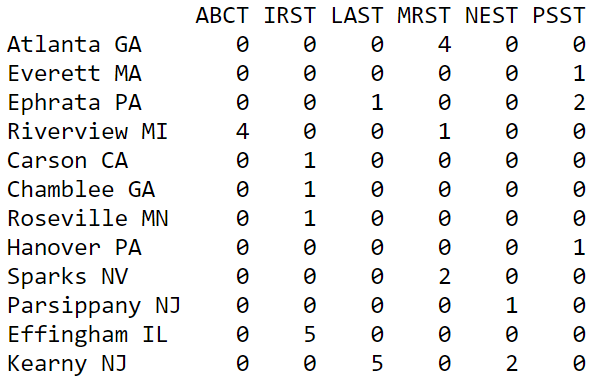

The cost of each route by specific carrier is calculated with the cost per mile * miles of the route + stops required to the destination * the cost of making each stop. In case that the cost of each route by specific carrier is not greater than the minimum cost of a single trip by the carrier, we substitute the cost with the minimum cost. Considering the trips needed to the 12 destinations, the minimum commitment required by carriers, and the trucks available by each carrier. We came up with this optimal solution with least cost assignment, $22,394.


## Approach and Challenges 

For a better display of the model, I decided to create pandas data frames to display the steps in the model. The first challenge for me was to figure out a way to iterate through pandas data frames elements. It took me a while to figure out that “pandas.iloc” is what I was looking for. This is also a good for loop practice and I am glad that I was able to throw in some list comprehension to make the code look cleaner.